# Plotting 3D houses

## Import libraries

In [37]:
import json
import requests

from pathlib import Path
import rasterio

import geopandas as gpd
from shapely.geometry import Point

## Get Lambert72 coordinates from the API with given address

In [19]:
def get_coordinates(address):
    
    response = requests.get(f"https://loc.geopunt.be/v4/location?q={address}")
    data = json.loads(response.content)
    
    long_x_lambert72 = data['LocationResult'][0]['Location']['X_Lambert72']
    lat_y_lambert72 = data['LocationResult'][0]['Location']['Y_Lambert72']
    
    return int(long_x_lambert72),int(lat_y_lambert72)

In [12]:
address = "Victor Braeckmanlaan 185, 9040 Ghent"

In [11]:
X_lambert72, Y_Lambert72 = get_coordinates(address)
X_lambert72, Y_Lambert72

(107011, 194663)

## Get DSM number containing the Lambert72 coordinates

In [22]:
def get_DSM_number(x, y, folder_path):
    folder_path = Path(folder_path)
    for file in folder_path.glob(f"**/*.tif"):
        dataset = rasterio.open(file)
        bound = dataset.bounds
        if x >= bound[0] and x <= bound[2] and y >= bound[1] and y <= bound[3]:
            number = file.name.split('.')[0][-2:]
            return number
        else:
            print('not this file', file.name)

In [23]:
DSM_path = "/Users/cerenmorey/Desktop/3D_Project/DSM"
DTM_path = "/Users/cerenmorey/Desktop/3D_Project/DTM"

In [28]:
number = get_DSM_number(X_lambert72,Y_Lambert72,DSM_path)
number

not this file DHMVIIDSMRAS1m_k04.tif
not this file DHMVIIDSMRAS1m_k03.tif
not this file DHMVIIDSMRAS1m_k35.tif
not this file DHMVIIDSMRAS1m_k32.tif
not this file DHMVIIDSMRAS1m_k33.tif
not this file DHMVIIDSMRAS1m_k34.tif
not this file DHMVIIDSMRAS1m_k02.tif
not this file DHMVIIDSMRAS1m_k05.tif
not this file DHMVIIDSMRAS1m_k42.tif
not this file DHMVIIDSMRAS1m_k18.tif
not this file DHMVIIDSMRAS1m_k27.tif
not this file DHMVIIDSMRAS1m_k20.tif
not this file DHMVIIDSMRAS1m_k29.tif
not this file DHMVIIDSMRAS1m_k19.tif
not this file DHMVIIDSMRAS1m_k11.tif
not this file DHMVIIDSMRAS1m_k43.tif
not this file DHMVIIDSMRAS1m_k10.tif
not this file DHMVIIDSMRAS1m_k28.tif
not this file DHMVIIDSMRAS1m_k17.tif
not this file DHMVIIDSMRAS1m_k21.tif
not this file DHMVIIDSMRAS1m_k26.tif
not this file DHMVIIDSMRAS1m_k07.tif
not this file DHMVIIDSMRAS1m_k38.tif
not this file DHMVIIDSMRAS1m_k31.tif
not this file DHMVIIDSMRAS1m_k36.tif
not this file DHMVIIDSMRAS1m_k09.tif
not this file DHMVIIDSMRAS1m_k37.tif
n

'22'

## Download the corresponding DTM file from the website
*Only download the relevant DTM file because I don't have enough memory on my computer.*

In [17]:
def download_dtm(url, save_path, chunk_size=128):
    file = Path(save_path)
    r = requests.get(url, stream=True)
    with open(save_path, 'wb') as fd:
        print(f"Downloading {file.name}")
        total_length = r.headers.get('content-length')
        if total_length is None:  
            fd.write(r.content)
        else:
            dl = 0
            total_length = int(total_length)
            for chunk in r.iter_content(chunk_size=chunk_size):
                dl += len(chunk)
                fd.write(chunk)
                print(f"{round(100*dl/total_length,2)}% processed")
    z = zipfile.ZipFile(io.BytesIO(r.content))
    z.extractall(str(file.parents[0]))

In [27]:
url = f'https://downloadagiv.blob.core.windows.net/dhm-vlaanderen-ii-dtm-raster-1m/DHMVIIDTMRAS1m_k{number}.zip'
save_path = f'/Users/cerenmorey/Desktop/3D_Project/DTM/DHMVIIDTMRAS1m_k{number}.zip'

download_dtm(url, save_path = save_path)

## Get CHM function

In [66]:
def get_chm():

    DSM_file_path = f"/Users/cerenmorey/Desktop/3D_Project/DSM/DHMVIIDSMRAS1m_k{number}/GeoTIFF/DHMVIIDSMRAS1m_k{number}.tif"
    DTM_file_path = f"/Users/cerenmorey/Desktop/3D_Project/DTM/DHMVIIDTMRAS1m_k{number}/GeoTIFF/DHMVIIDTMRAS1m_k{number}.tif"

    
    dsm = rasterio.open(DSM_file_path, driver = 'GTiff')
    dtm = rasterio.open(DTM_file_path, driver = 'GTiff')
    
    chm = dsm.read(masked=True) - dtm.read(masked=True)
    
    return chm

In [67]:
get_chm()

masked_array(
  data=[[0.0, 0.0, 0.0, ..., 0.0, 0.0, 0.0],
        [0.0, 0.0, 0.0, ..., 0.0, 0.0, 0.0],
        [0.0, 0.0, 0.009999752044677734, ..., 0.0, 0.0, 0.0],
        ...,
        [4.859999656677246, 5.290000915527344, 5.700000762939453, ...,
         0.0, 0.0, 0.0],
        [1.5700006484985352, 5.960000038146973, 5.660000801086426, ...,
         0.0, 0.0, 0.0],
        [0.039999961853027344, 0.0, 0.5699996948242188, ..., 0.0, 0.0,
         0.0]],
  mask=[[False, False, False, ..., False, False, False],
        [False, False, False, ..., False, False, False],
        [False, False, False, ..., False, False, False],
        ...,
        [False, False, False, ..., False, False, False],
        [False, False, False, ..., False, False, False],
        [False, False, False, ..., False, False, False]],
  fill_value=-9999.0,
  dtype=float32)

## Get Polygon coordinates from the CaBu file

In [61]:
def get_polygon_coordinates(X_lambert72,Y_Lambert72, cabu_file):

    coord = Point(X_lambert72,Y_Lambert72)
    

    geo = gpd.read_file(cabu_file,mask = coord)
    polygon_coordinates = geo['geometry'][1]
    
    return polygon_coordinates

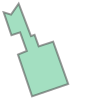

In [62]:
cabu_file = '/Users/cerenmorey/Desktop/Belgium_L72_2018/Bpn_CaBu.shp'
polygon_coordinates = get_polygon_coordinates(X_lambert72,Y_Lambert72, cabu_file)
polygon_coordinates